# Projeto de Análise de Dados de E-commerce

## Introdução

O setor de e-commerce tem crescido exponencialmente, sendo uma fonte rica de dados que, quando analisados, podem fornecer insights valiosos sobre o comportamento do consumidor. No entanto, conjuntos de dados de e-commerce geralmente são proprietários e não estão disponíveis para pesquisa pública.

Esse projeto utiliza o conjunto de dados "Online Retail", disponibilizado pelo UCI Machine Learning Repository (https://www.kaggle.com/datasets/carrie1/ecommerce-data), que reúne transações de um varejista online baseado no Reino Unido entre dezembro de 2010 e dezembro de 2011.

Com a análise deste conjunto de dados, o projeto busca entender padrões de compra, segmentar consumidores e definir estratégias para retenção e fidelização, com potencial aplicação em otimização de campanhas e marketing direcionado.

### Sobre o conjunto de dados

**Origem**: Transações realizadas em um varejo online do Reino Unido.  
**Período**: 01/12/2010 a 09/12/2011.  
**Descrição**: A empresa vende principalmente presentes exclusivos e atende tanto consumidores finais quanto atacadistas.  

## Objetivos


### Objetivo Geral:

- Analisar o comportamento de compra dos clientes através de técnicas de segmentação, métricas de valor do cliente e modelos de agrupamento.

### Objetivos Específicos:

- Realizar tratamento de dados para garantir a qualidade e confiabilidade das análises.  

- Implementar análises de cohort para entender a retenção e o comportamento ao longo do tempo.  

- Aplicar a Análise de Pareto para identificar os clientes mais valiosos (20% dos clientes responsáveis por 80% das vendas).

- Realizar uma análise de RFM (Recência, Frequência e Valor Monetário) para segmentação de clientes.

- Utilizar técnicas de clusterização para identificar padrões de clientes e potencializar estratégias de marketing personalizadas.


## Limpeza e Transformação de Dados

Nesta parte, iremos realizar o tratamento dos dados, que inclui a identificação e correção de valores ausentes e remoção de transações com devoluções ou erros.

### Importando bibiotecas

Primeiramente, vamos importar as bibliotecas necessárias para o tratamento e a análise dos dados.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### Lendo base de dados

Em seguida, lemos o arquivo com a biblioteca Pandas e o transformamos em um dataframe para facilitar o tratamento e a análise dos dados

In [13]:
base = pd.read_csv("data.csv", encoding='latin1')

### Descrição dos dados

**InvoiceNo:** Código que representa cada transação única. Se o código começa com 'c', indica um cancelamento.   
**StockCode:** Código atribuído exclusivamente a cada produto distinto (código de estoque).  
**Description:** Descrição de cada produto.  
**Quantity:** Quantidade de unidades de um produto em uma transação.  
**InvoiceDate:** Data e hora da transação.  
**UnitPrice:** Preço unitário do produto em libras esterlinas.  
**CustomerID:** Identificador único atribuído a cada cliente.  
**Country:** País do cliente.  

## Análise inicial

### Visão geral da base de dados

O próximo passo é entender o formato da base e seus campos antes de prosseguir para a etapa de tratamento dos dados.

In [15]:
base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [17]:
base.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [19]:
base.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [21]:
missing_data = base.isnull().sum() # Valores nulos
total_records = base.shape[0] # Quantidade de registros
data_types = base.dtypes # Verificando tipo de dado

# Criando um dataframe com as informações sobre a base analisada
summary_table = pd.DataFrame({
    'Tipo de dado': data_types,
    'Quantidade de registros': total_records,
    'Registros não nulos': total_records - missing_data,
    'Registros nulos': missing_data,
    'Percentual de nulos (%)': round((missing_data / total_records) * 100,2)
})

summary_table

,Tipo de dado,Quantidade de registros,Registros não nulos,Registros nulos,Percentual de nulos (%)
InvoiceNo,object,541909,541909,0,0.00
StockCode,object,541909,541909,0,0.00
Description,object,541909,540455,1454,0.27
Quantity,int64,541909,541909,0,0.00
InvoiceDate,object,541909,541909,0,0.00
UnitPrice,float64,541909,541909,0,0.00
CustomerID,float64,541909,406829,135080,24.93
Country,object,541909,541909,0,0.00


Aqui, já conseguimos identificar algumas oportunidades:

- **CustomerID**, que deveria ser uma variável de texto, está no formato numérico (vamos precisar converter);
- **InvoiceDate** está no formato de objeto e precisa ser convertido para formato de data;
- Além disso, há alguns dados nulos no dataframe, e será necessário decidir se vamos mantê-los ou excluí-los antes de prosseguir com a análise dos dados.
- **Quantity** e **UnitPrice** apresentam valores negativos, indicando que provavelmente são casos de cancelamentos.

### Dados nulos

Para construir uma base mais confiável e limpa, vamos remover os dados ausentes das colunas **CustomerID** e **Description**:

In [23]:
print("A base inicial possui {} observações.".format(base.shape[0]))

# Removendo linhas com valores ausentes nas colunas 'CustomerID' e 'Description'
base = base.dropna(subset=['CustomerID', 'Description'])

print("Após excluir os casos nulos, temos {} observações.".format(base.shape[0]))

A base inicial possui 541909 observações.
Após excluir os casos nulos, temos 406829 observações.


In [16]:
base.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Verificando casos duplicados

Agora, vamos identificar se temos informações duplicadas em nossa base de dados.

In [27]:
# Identificando valores duplicados
duplicate_rows = base[base.duplicated(keep=False)]

# Ordenando as colunas para verificar valores próximos
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [29]:
# Mostrando a quantidade de linhas duplicadas
print(f"A base de dados contém {base.duplicated().sum()} linhas duplicadas que serão removidas.")

# Removendo linhas duplicadas
base = base.drop_duplicates()

# Mostrando nova quantidade do dataframe
print(f"Agora, o dataframe possui {base.shape[0]} linhas.")

A base de dados contém 5225 linhas duplicadas que serão removidas.
Agora, o dataframe possui 401604 linhas.


### Tratando operações canceladas

Aqui, a estratégia consiste em remover os casos cancelados e prosseguir com a análise dos dados.

In [31]:
# Cria uma nova coluna "Cancelled" usando np.where
base["status_operacao"] = np.where(base["InvoiceNo"].str.startswith("C"), 1, 0)

base[base["status_operacao"] == 1].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,status_operacao
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1


Confirmamos que os casos negativos correspondem a transações canceladas.

In [33]:
base[['Quantity']][base["status_operacao"] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,8872.0,-30.77491,1172.249902,-80995.0,-6.0,-2.0,-1.0,-1.0


In [35]:
# Calculando o número de registros com status_operacao igual a 1
num_records = base[base["status_operacao"] == 1].shape[0]

# Calculando a porcentagem de registros com status_operacao igual a 1 em relação ao total da base
percentage = round(num_records / base.shape[0] * 100,2)

# Exibindo o resultado
print(f"Número de registros cancelados: {num_records}")
print(f"Porcentagem em relação à base total: {percentage}%")

# Retirando cancelados
base = base[base["status_operacao"] == 0]

# removendo coluna de status da operação
base = base.drop(columns=['status_operacao'])

Número de registros cancelados: 8872
Porcentagem em relação à base total: 2.21%


###  Tratando StockCode (código de estoque)


Observamos que, enquanto a maioria dos códigos de estoque é composta por 5 ou 6 caracteres, há também exceções que precisam ser analisadas.

In [37]:
# Agrupando e contando o número de linhas pelo comprimento dos códigos de estoque
length_counts = base['StockCode'].apply(len).value_counts().sort_index()

length_counts

StockCode
1        285
2        133
3         16
4       1103
5     358309
6      32583
7        291
12        12
Name: count, dtype: int64

Além da diferença no tamanho do código, também temos variações em seu formato. Alguns códigos possuem apenas números, enquanto outros contêm letras. Além disso, existem alguns casos com o nome "POST", que provavelmente representa algum tipo diferente de serviço.

In [39]:
base[~base['StockCode'].str.isnumeric()].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.00,12583.0,France


In [41]:
print(f"Existem {base[base['StockCode'] == 'POST'].shape[0]} casos que possuem o nome POST")

Existem 1099 casos que possuem o nome POST


Nesse caso, desconsideraremos os casos acima, pois eles fogem ao padrão dos demais códigos.

In [43]:
base = base[base['StockCode'] != "POST"]

Além desses casos, é importante verificar se não encontramos outros tipos com esse padrão semelhante:

In [36]:
base['StockCode'][base['StockCode'].str.isalpha()].unique()

array(['M', 'PADS', 'DOT'], dtype=object)

Além do POST, temos os casos M, PADS e DOT que iremos filtrar em nossa base.

In [45]:
base = base[~base['StockCode'].isin(['M', 'PADS', 'DOT'])]

###  Verificando valores

In [40]:
base[['UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
UnitPrice,391328.0,2.890526,4.375581,0.0,1.25,1.95,3.75,649.5


Identificamos que o valor mínimo é zero, indicando que algum valor foi inserido de forma incorreta. Nesse caso, iremos remover essas transações da base de dados.

In [42]:
base[base['UnitPrice'] == 0][['UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
UnitPrice,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
base = base[base['UnitPrice'] > 0]

### Convertendo colunas

In [49]:
base['InvoiceDate'] = pd.to_datetime(base['InvoiceDate'])

base['CustomerID'] = base['CustomerID'].astype(int).astype(str)

Agora que finalizamos a nossa base de dados, vamos avançar para as próximas etapas do projeto.

In [48]:
print(f"A base final possui {base.shape[0]} linhas")

A base final possui 391295 linhas


## Análise descritiva

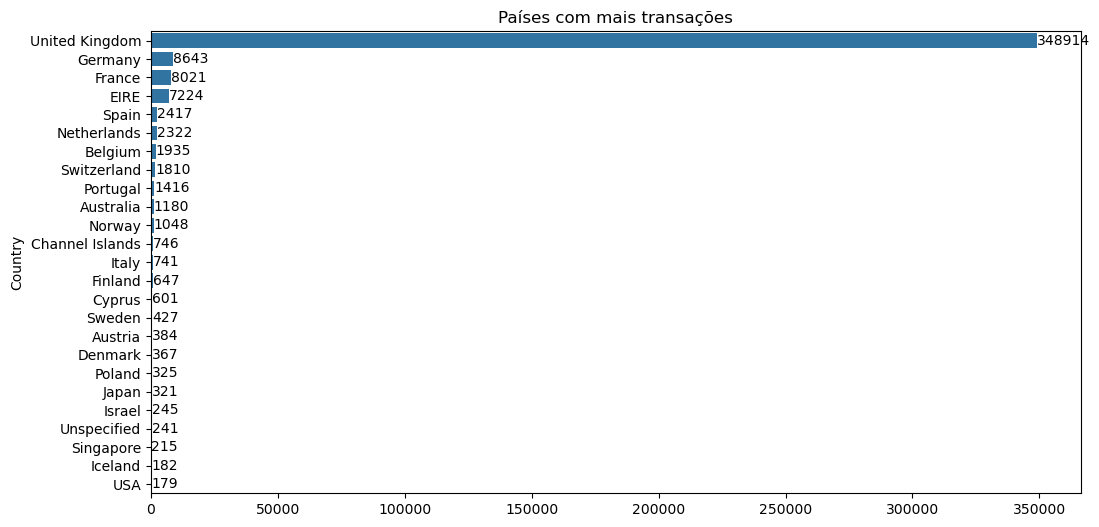

In [51]:
# 25 países com mais transações
country_counts = base.Country.value_counts().sort_values(ascending=False).head(25)

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=country_counts.values, y=country_counts.index, orient="h", ax=ax, order=country_counts.index)

# Título do gráfico
plt.title("Países com mais transações")

# Rótulos aos dados nas barras
for i, value in enumerate(country_counts.values):
    ax.text(value, i, f'{value}', ha='left', va='center', fontsize=10)

plt.show()

- A análise das transações por país revela que o **Reino Unido** domina amplamente o volume de transações, totalizando 348.914, representando a maior parte das vendas.  

- Após o Reino Unido, os países com maior número de transações são **Alemanha** (8.643), **França** (8.021) e **Irlanda** (7.224). Esses três países, ainda que significativamente menores em volume de transações comparado ao Reino Unido, mostram alguma relevância, sugerindo mercados secundários importantes para a empresa.  

- Outros países europeus como **Espanha**, **Países Baixos**, **Bélgica** e **Suíça** também figuram no topo, enquanto regiões como **Estados Unidos** e **Japão** aparecem com volumes muito menores.  

- Notamos ainda a presença de uma categoria "Unspecified" (sem especificação) com 241 transações. Este dado pode indicar registros incompletos ou compras de locais não identificados, que podem necessitar de tratamento adicional para melhor análise e segmentação dos clientes.entes.

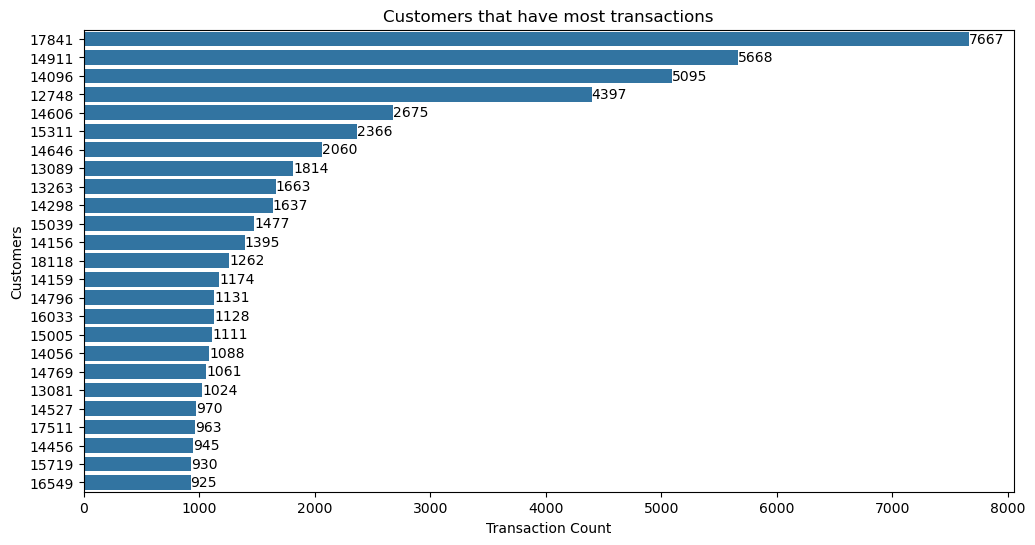

In [35]:
# 25 clientes com mais transações
customer_counts = base.CustomerID.value_counts().sort_values(ascending=False).head(25)

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(y=customer_counts.index, x=customer_counts.values, orient="h", ax=ax, order=customer_counts.index)

# Título e rótulos dos eixos
plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

# Rótulos aos dados nas barras
for i, value in enumerate(customer_counts.values):
    ax.text(value, i, f'{value}', ha='left', va='center', fontsize=10)

plt.show()

- Analisando as transações por usuário, vemos queque alguns clientes são responsáveis por um volume considerável de transações, o que sugere uma base de clientes frequentes e possivelmente leais. O cliente com o maior número de transações possui um total de **7.667** compras, seguido por outros usuários com transações variando entre **5.668** e **925**. 

- A concentração de um alto volume de transações em poucos clientes pode ser uma oportunidade para estratégias personalizadas de fidelização, além de um risco se esses clientes representarem uma grande parte do faturamento, pois uma eventual perda poderia impactar significativamente as receitas.

### Verificação e remoção de outlier

Para evitar possiveis distorções na base de dados, iremos identificar outliers com base nos quartis da variável `Quantity`.

Calculamos o primeiro quartil (Q1, 25%) e o terceiro quartil (Q3, 75%) para obter o **Intervalo Interquartil** (IQR), representando a faixa onde se concentra a maior parte dos valores.

Com o IQR em mãos, definimos os limites para identificar os outliers:

- O **limite inferior** é dado por $$ Q1 - 1.5 \times IQR $$
- O **limite superior** é dado por $$ Q3 + 1.5 \times IQR $$

Qualquer valor fora dessa faixa é classificado como outlier.

Para aplicar a remoção, filtramos a base de dados, mantendo apenas os valores de `Quantity` dentro dos limites calculados. Essa filtragem reduz o impacto de valores extremos, evitando que influenciem negativamente as análises.

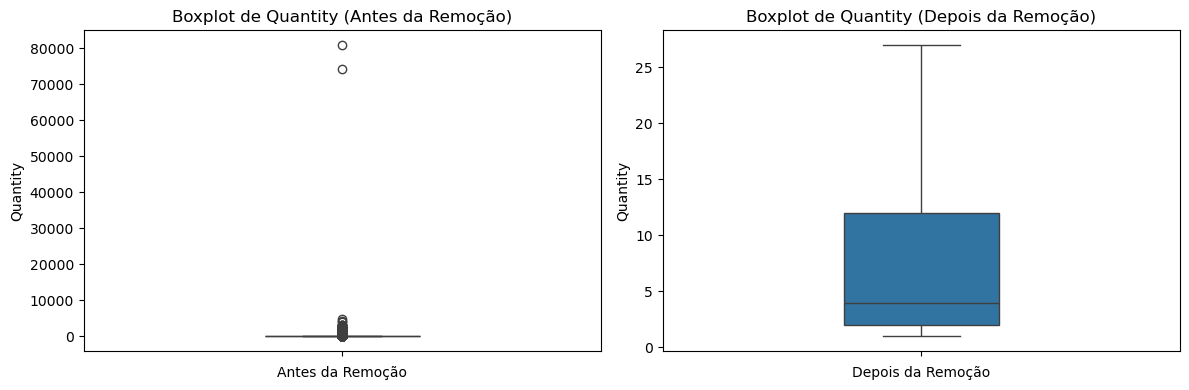

In [53]:
# Criar subplots
plt.figure(figsize=(12, 4))  # Ajustar o tamanho da figura para comportar ambos os boxplots lado a lado

# Boxplot antes da remoção dos outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=base['Quantity'], width=0.3)  # Diminuir a largura do boxplot
plt.title('Boxplot de Quantity (Antes da Remoção)', fontsize=12)
plt.ylabel('Quantity', fontsize=10)
plt.xlabel('Antes da Remoção', fontsize=10)

# Calcular Q1 (25º percentil) e Q3 (75º percentil)
Q1 = base['Quantity'].quantile(0.25)
Q3 = base['Quantity'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Definir limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar os outliers
base_cleaned = base[(base['Quantity'] >= lower_bound) & (base['Quantity'] <= upper_bound)]

# Boxplot depois da remoção dos outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=base_cleaned['Quantity'], width=0.3)  # Diminuir a largura do boxplot
plt.title('Boxplot de Quantity (Depois da Remoção)', fontsize=12)
plt.ylabel('Quantity', fontsize=10)
plt.xlabel('Depois da Remoção', fontsize=10)

# Ajustar layout
plt.tight_layout()
plt.show()


In [55]:
# Comparando antes de deopis
pd.concat(
    [base[['Quantity']].describe().T,
    base_cleaned[['Quantity']].describe().T], 
    axis=0, 
    keys=['Base', 'Base sem outliers']
)

,,count,mean,std,min,25%,50%,75%,max
Base,Quantity,391295.0,13.140802,180.774478,1.0,2.0,6.0,12.0,80995.0
Base sem outliers,Quantity,365701.0,7.110530,6.676225,1.0,2.0,4.0,12.0,27.0


Após a remoção dos outliers, a base apresenta uma redução na média de `Quantity` de 13,14 para 7,11 e no desvio padrão de 180,77 para 6,68, refletindo uma distribuição mais uniforme. Além disso, o valor máximo foi reduzido de 80.995 para 27, mostrando que os valores extremos foram eliminados, o que torna a análise mais precisa e representativa da maioria dos dados.

In [55]:
# Filtrar os outliers da base original
base = base[(base['Quantity'] >= lower_bound) & (base['Quantity'] <= upper_bound)]

A próxima etapa será a elaboração dos cohorts e a análise da evolução da retenção dos usuários ao longo do tempo.

# Cohort

A análise *cohort* agrupa usuários ou clientes com características ou comportamentos comuns em períodos específicos, como data de aquisição, permitindo observar o comportamento de diferentes grupos ao longo do tempo. Com isso, é possível acompanhar métricas como taxa de retenção e engajamento, além de entender padrões que ajudam a prever a probabilidade de renovação.

Esse método facilita a segmentação detalhada da base de usuários, ajudando a identificar ações proativas para maximizar o ciclo de vida dos clientes e aumentar o engajamento de forma estratégica.

In [59]:
min_date = base['InvoiceDate'].min().strftime('%d/%m/%Y')
max_date = base['InvoiceDate'].max().strftime('%d/%m/%Y')

print("A base analisada vai de {} até {}".format(min_date, max_date))

A base analisada vai de 01/12/2010 até 09/12/2011


Vamos agrupar os clientes com base na sua primeira transação. O índice de cohort será o número de meses desde a primeira transação

In [61]:
base_cohort = base.copy()

base_cohort = base_cohort[(base_cohort['InvoiceDate']) <= '2011-11-30'] # Filtrando o mes de dezembro para considerar apenas meses cheios

# Identificando o primeiro depósito de cada usuário
base_cohort['primeira_transacao'] = base_cohort.groupby('CustomerID')['InvoiceDate'].transform('min')

# Garantir que 'primeira_transacao' esteja no formato datetime
base_cohort['primeira_transacao'] = pd.to_datetime(base_cohort['primeira_transacao'])

# Calcular quantos meses desde o primeiro depósito (definir como mês do cohort)
base_cohort['cohort_month'] = base_cohort['primeira_transacao'].dt.to_period('M')

# Calcular os meses desde o primeiro depósito de forma correta
base_cohort['months_since_first'] = ((base_cohort['InvoiceDate'] - base_cohort['primeira_transacao']).dt.days // 30).astype(int)

# Visualizar os dados
base_cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,primeira_transacao,cohort_month,months_since_first
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12,0


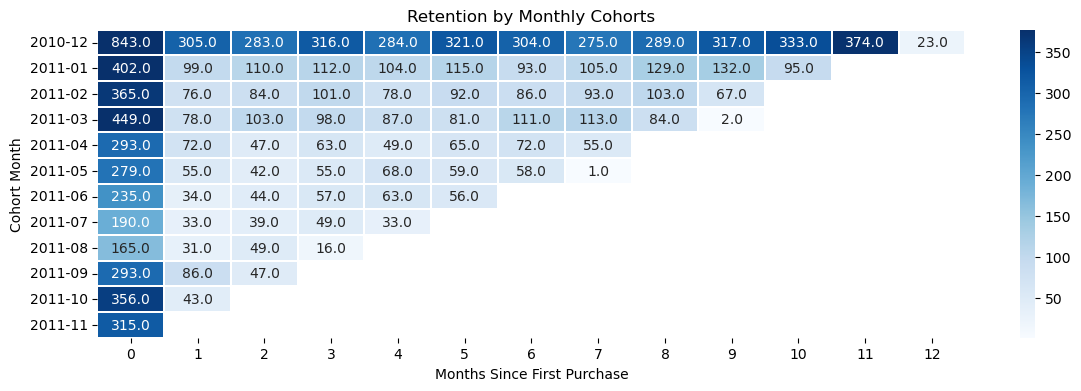

In [63]:
cohort_data = base_cohort.groupby(['cohort_month', 'months_since_first'])['CustomerID'].nunique().unstack(fill_value=0) # Para ver a tabela de cohorts

cohort_data = cohort_data.mask(cohort_data == 0) # Substituir zeros por NaN

plt.figure(figsize=(14, 4)) # Configurar o tamanho da figura

plt.title('Retention by Monthly Cohorts') # Configurar o título do gráfico

# Criar um heatmap com os dados de coorte
sns.heatmap(
    cohort_data.round(2),                   # Arredondar os valores para 2 casas decimais
    annot=True,                             # Mostrar os valores na célula
    cmap="Blues",                           # Colormap
    vmax=list(cohort_data.max().sort_values(ascending=False))[1] + 3,  # Definir o valor máximo para a coloração
    fmt='.1f',                              # Formato dos valores anotados
    linewidths=0.3,                         # Largura das linhas que separam as células
    yticklabels=cohort_data.index.strftime('%Y-%m')  # Rótulos do eixo y
)

plt.yticks(rotation=0) # Ajustar os rótulos do eixo y para que apareçam na horizontal

# Adicionar rótulos para os eixos
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')

plt.show() # Exibir o gráfico

A tabela de cohorts acima mostra a retenção de clientes ao longo do tempo, agrupados por mês de primeira transação. Por exemplo, temos 843 clientes únicos cuja primeira transação ocorreu em dezembro de 2010. O mês de cohort para esses clientes é 2010-12.

Se olharmos para a primeira linha, na coluna correspondente a "months_since_first" igual a 1 (janeiro de 2011), encontramos o número 305. Isso significa que, dos 843 clientes que iniciaram suas transações em dezembro de 2010, 305 permaneceram ativos no mês seguinte, indicando uma taxa de retenção significativa.

Ao longo dos meses, podemos observar uma tendência de queda no número de clientes.

### Taxa de retenção

A taxa de retenção é a porcentagem de clientes ativos em um determinado período que ainda são clientes no próximo período. 

$$
\text{Taxa de retenção de usuários} = \left( \frac{\text{Número de usuários ativos no período}}{\text{Número total de usuários ativos no período inicial}} \right) \times 100
$$

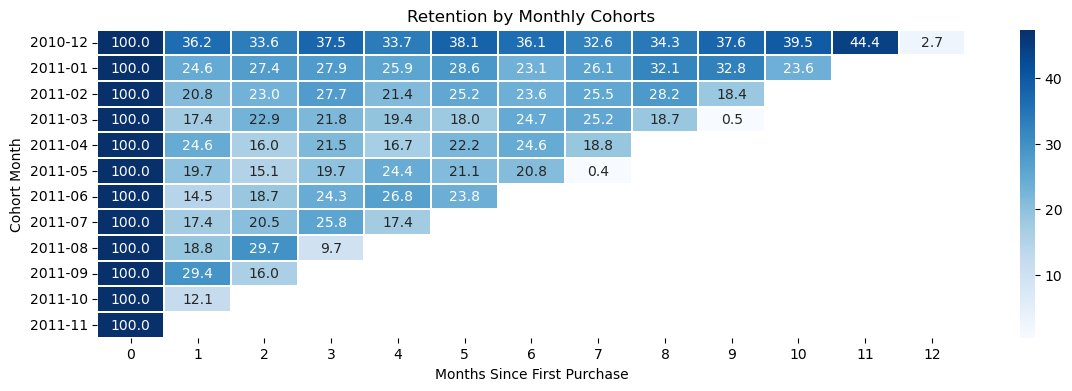

In [65]:
# Agrupar os dados de transações por mês de coorte e meses desde o primeiro
cohort_data = base_cohort.groupby(['cohort_month', 'months_since_first'])['CustomerID'].nunique().unstack(fill_value=0)

# Substituir zeros por NaN para melhor visualização no heatmap
cohort_data = cohort_data.mask(cohort_data == 0)

# Calcular a retenção percentual
# O primeiro valor de cada coorte (mês 0) é usado como base
retention_percent = cohort_data.div(cohort_data.iloc[:, 0], axis=0) * 100  # Multiplica por 100 para converter em percentual

# Configurar o tamanho da figura
plt.figure(figsize=(14, 4))

# Configurar o título do gráfico
plt.title('Retention by Monthly Cohorts')

# Criar um heatmap com os dados de coorte
sns.heatmap(
    retention_percent.round(2),                   # Arredondar os valores para 2 casas decimais
    annot=True,                             # Mostrar os valores na célula
    cmap="Blues",                           # Colormap
    vmax=list(retention_percent.max().sort_values(ascending=False))[1] + 3,  # Definir o valor máximo para a coloração
    fmt='.1f',                              # Formato dos valores anotados
    linewidths=0.3,                         # Largura das linhas que separam as células
    yticklabels=retention_percent.index.strftime('%Y-%m')  # Rótulos do eixo y
)

# Ajustar os rótulos do eixo y para que apareçam na horizontal
plt.yticks(rotation=0)  # Rotaciona os rótulos do eixo y para 0 graus

# Adicionar rótulos para os eixos
plt.xlabel('Months Since First Purchase')  # Legenda do eixo x
plt.ylabel('Cohort Month')                  # Legenda do eixo y

# Exibir o gráfico
plt.show()

Para o cohort de dezembro de 2010, a taxa de retenção inicia em 100%, caindo para 36,2% no segundo mês (janeiro de 2011), indicando que cerca de 36% dos clientes iniciais ainda estavam ativos. Nos meses seguintes, a retenção oscila, mas mantém uma tendência de redução, chegando a 2,7% no mês 12.

No cohort de janeiro de 2011, a retenção também começa em 100%, mas cai rapidamente para 24,6% no segundo mês, alcançando 23,6% no décimo primeiro. Essa queda acentuada sugere menor engajamento entre os clientes adquiridos nesse período.

Em geral, os cohorts mostram taxas de retenção decrescentes ao longo do tempo, destacando um desafio constante em manter os clientes engajados.

### Taxa de retenção (gráfico de safras)

Uma outra forma de analisar a taxa de retenção é por meio de "safras" apresentadas em gráfico. Nela, conseguimos visualizar e comparar melhor os cohorts mensais.

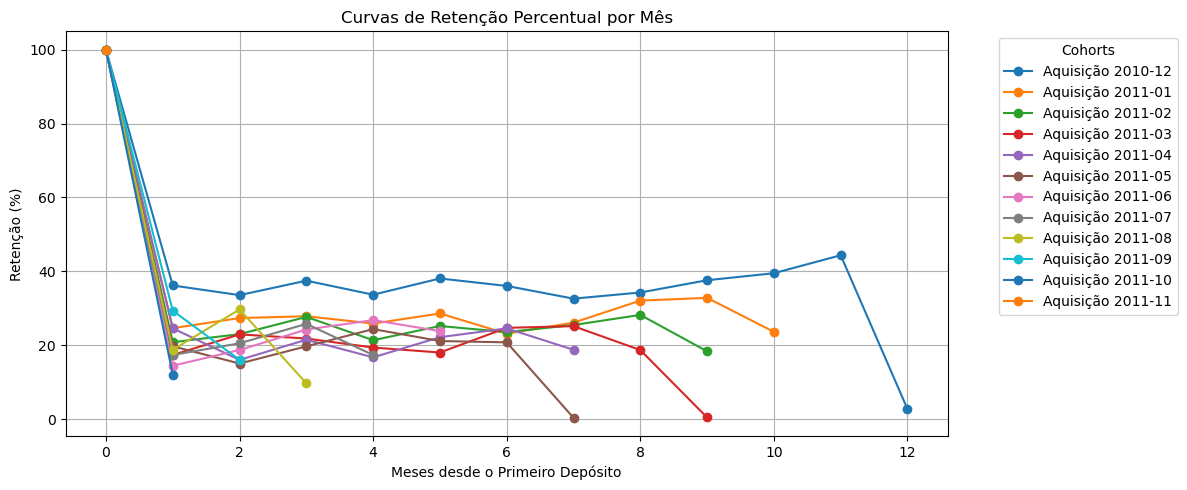

In [67]:
# Plotar a retenção percentual com a média geral, desconsiderando zeros
def plot_retention(retention_table):
    plt.figure(figsize=(12, 5))
    # Usar mask para substituir zeros por NaN
    retention_table = retention_table.mask(retention_table == 0)
    
    for index, row in retention_table.iterrows():
        plt.plot(row.index, row.values, marker='o', label=f'Aquisição {index}')

    plt.title('Curvas de Retenção Percentual por Mês')
    plt.xlabel('Meses desde o Primeiro Depósito')
    plt.ylabel('Retenção (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Cohorts', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plotar a retenção percentual
plot_retention(retention_percent)

### Taxa de retenção (média)

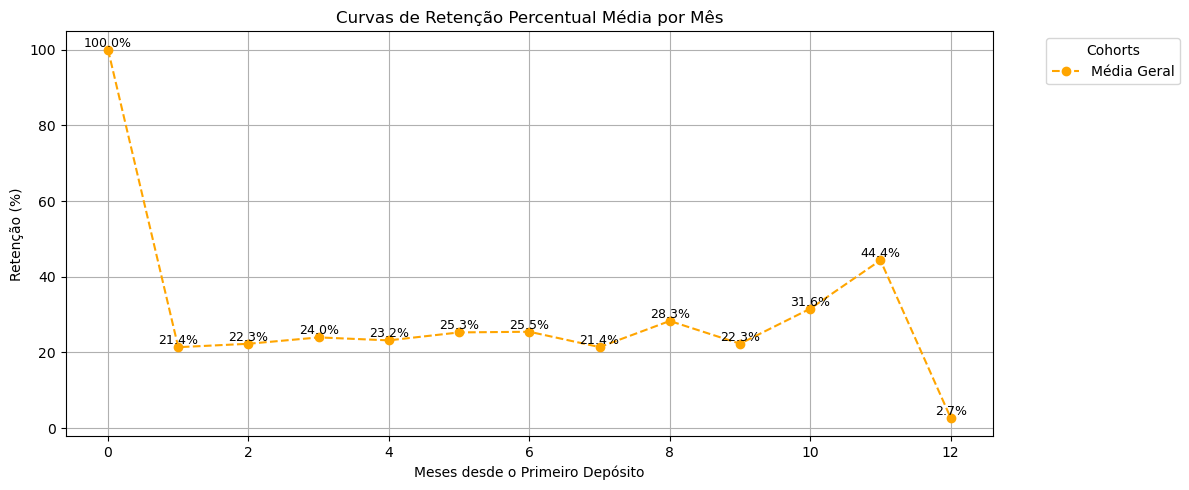

In [69]:
# Calcular a média geral de retenção percentual desconsiderando zeros
average_retention = retention_percent.replace(0, np.nan).mean()

# Plotar a retenção percentual apenas com a média geral
def plot_retention(average_retention):
    plt.figure(figsize=(12, 5))
    
    # Plotar média geral
    plt.plot(average_retention.index, average_retention.values, marker='o', color='orange', linestyle='--', label='Média Geral')

    # Adicionar valores aos pontos
    for i, value in enumerate(average_retention.values):
        plt.text(average_retention.index[i], value, f'{value:.1f}%', 
                 ha='center', va='bottom', fontsize=9)

    plt.title('Curvas de Retenção Percentual Média por Mês')
    plt.xlabel('Meses desde o Primeiro Depósito')
    plt.ylabel('Retenção (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Cohorts', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plotar a média de retenção percentual
plot_retention(average_retention)


A média das taxas de retenção mostra que:
- Após a primeira transação (100%), ocorre uma queda acentuada para cerca de 21,4% no mês seguinte, estabilizando entre 22% e 25% até o sexto mês.  
- O mês 8 se destaca com um leve aumento para 28,3%, sugerindo alguma intervenção positiva.  
- No mês 11, há um pico incomum de 44,4%, possivelmente devido a uma campanha ou ação de retenção eficaz, mas a taxa cai drasticamente para 2,7% no mês 12.

A análise indica uma retenção instável, com oportunidades para melhorar a fidelização ao longo do tempo.

### Planos de ação

1. Como a retenção cai logo após a primeira compra, ações de pós-compra, como ofertas de frete grátis na próxima compra, descontos exclusivos para recompra, ou sugestões de produtos complementares, podem ser enviadas por e-mail ou notificações push. O objetivo é reduzir o tempo entre a primeira e a segunda compra.

2. Enviar recomendações personalizadas ou combos de produtos relacionados aos que o cliente já comprou pode aumentar o engajamento e melhorar as taxas de retenção do terceiro ao sexto mês.

3. Aproveitar sazonalidades como Natal ou outras datas promocionais para impulsionar as compras em períodos com menor retenção. O aumento observado no mês 8 pode ser estudado para identificar práticas eficazes, como promoções, e replicá-las.

4. Criar um programa de fidelidade pode incentivar a recompra ao longo do ano. Oferecer benefícios como pontos por compras, descontos acumulativos ou acesso antecipado a novos produtos pode manter o cliente ativo no e-commerce.

5. Para clientes que não compram há mais de 6 meses, uma campanha de reativação com ofertas de retorno, como desconto de boas-vindas para compras de retorno, pode atrair esses consumidores de volta. Campanhas sazonais exclusivas para clientes inativos também podem reengajá-los no e-commerce.

## Pareto

O princípio de Pareto, conhecido como regra 80/20, afirma que 80% dos efeitos vêm de 20% das causas. Isso significa que, em diversas áreas, uma pequena parcela das causas gera a maior parte dos resultados. Esse princípio pode ser aplicado em gestão de tempo, negócios, vendas e produtividade: normalmente, uma pequena porção de tarefas, produtos ou clientes é responsável pela maior parte dos resultados ou lucros.

No dia a dia, o princípio pode ajudar a priorizar esforços e recursos, direcionando mais atenção para o que traz mais retorno. Ao identificar e focar nesses elementos-chave, organizações e indivíduos conseguem melhorar sua eficiência, otimizar recursos e maximizar o impacto das ações em várias frentes.

### Pareto de clientes

Para criar o gráfico de Pareto, precisamos calcular o preço total, que é obtido multiplicando o preço pela quantidade. Em seguida, somamos esse preço total para cada cliente. Depois disso, ordenamos os valores do maior para o menor e, por fim, calculamos a porcentagem acumulada para o gráfico de Pareto.

In [57]:
base["TotalPrice"] = base["Quantity"] * base["UnitPrice"]

base_pareto = base.copy()

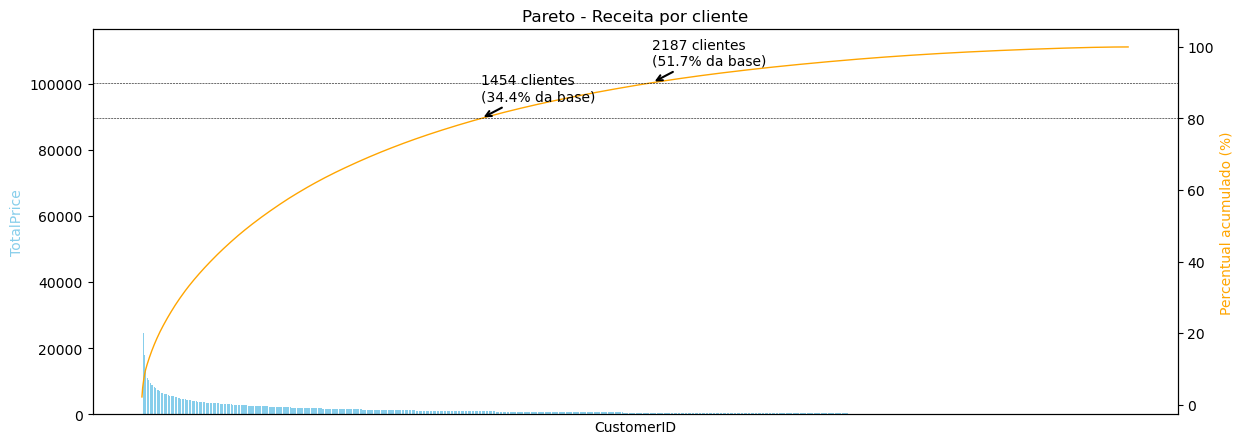

In [73]:
# Agrupar por 'CustomerID', somar 'TotalPrice', ordenar em ordem decrescente
pareto_df = base_pareto.groupby('CustomerID')['TotalPrice'].sum().reset_index()
pareto_df = pareto_df.sort_values(by='TotalPrice', ascending=False).reset_index(drop=True) #.head(100)

# Calcular porcentagem acumulada para o gráfico de Pareto
pareto_df['Percentual acumulado'] = pareto_df['TotalPrice'].cumsum() / pareto_df['TotalPrice'].sum() * 100

# Calcular a quantidade e porcentagem de clientes que representam 80% e 90% da receita
num_customers_80pct = pareto_df[pareto_df['Percentual acumulado'] <= 80].shape[0]
percentage_customers_80pct = (num_customers_80pct / pareto_df.shape[0]) * 100

num_customers_90pct = pareto_df[pareto_df['Percentual acumulado'] <= 90].shape[0]
percentage_customers_90pct = (num_customers_90pct / pareto_df.shape[0]) * 100

# Criar o gráfico de Pareto com as linhas de 80% e 90% e anotação ajustada para linha de porcentagem acumulada
fig, ax1 = plt.subplots(figsize=(14, 5))

# Barras para TotalPrice
ax1.bar(pareto_df['CustomerID'], pareto_df['TotalPrice'], color='skyblue')
ax1.set_xlabel('CustomerID')
ax1.set_ylabel('TotalPrice', color='skyblue')

# Linha para a porcentagem acumulada com uma linha mais fina
ax2 = ax1.twinx()
ax2.plot(pareto_df['CustomerID'], pareto_df['Percentual acumulado'], color='orange', linestyle='-', linewidth=1)  # Linha ajustada
ax2.set_ylabel('Percentual acumulado (%)', color='orange')

# Linhas de referência para 80% e 90%
ax2.axhline(80, color='black', linestyle='--', linewidth=0.4)  # Linha de 80%
ax2.axhline(90, color='black', linestyle='--', linewidth=0.4)  # Linha de 90%

# Adicionar anotações para 80% e 90% com ajustes na posição
ax2.annotate(f'{num_customers_80pct} clientes\n({percentage_customers_80pct:.1f}% da base)',
             xy=(num_customers_80pct, 80), xycoords='data',
             xytext=(num_customers_80pct + 1, 85), textcoords='data',  # Movido para cima
             arrowprops=dict(arrowstyle="->", lw=1.5, color='black'),
             color='black', fontsize=10)

ax2.annotate(f'{num_customers_90pct} clientes\n({percentage_customers_90pct:.1f}% da base)',
             xy=(num_customers_90pct, 90), xycoords='data',
             xytext=(num_customers_90pct + 1, 95), textcoords='data',  # Movido para cima
             arrowprops=dict(arrowstyle="->", lw=1.5, color='black'),
             color='black', fontsize=10)

# Ocultando os rótulos do eixo x
ax1.set_xticks([])

plt.title('Pareto - Receita por cliente')
plt.show()

In [75]:
print(f"""
- Ao analisar o gráfico de Pareto dos clientes, observamos que {round(percentage_customers_80pct, 1)}% da base de clientes ({num_customers_80pct} clientes) é responsável por 80% do valor transacionado. Além disso, {round(percentage_customers_90pct, 1)}% da base ({num_customers_90pct} clientes) responde por 90% do total transacionado.

- Esse resultado destaca a importância de focar na retenção e no engajamento desse grupo de clientes de alto valor. É recomendável implementar estratégias personalizadas, como atendimento ao cliente diferenciado e programas de fidelidade, para reter esses clientes.

- Uma parte significativa da base de clientes não contribui de forma proporcional para a receita. Isso representa uma oportunidade para desenvolver campanhas de marketing direcionadas que incentivem essas compras, além de avaliar e aprimorar produtos ou serviços que possam atrair uma maior participação desse grupo.

- Ter um resultado tão alto em poucos clientes pode representar um risco para a receita. Diversificar a base de clientes e entender os fatores que atraem os clientes de alto valor podem ajudar a criar um crescimento mais sustentável e reduzir vulnerabilidades financeiras.
""")


- Ao analisar o gráfico de Pareto dos clientes, observamos que 34.4% da base de clientes (1454 clientes) é responsável por 80% do valor transacionado. Além disso, 51.7% da base (2187 clientes) responde por 90% do total transacionado.

- Esse resultado destaca a importância de focar na retenção e no engajamento desse grupo de clientes de alto valor. É recomendável implementar estratégias personalizadas, como atendimento ao cliente diferenciado e programas de fidelidade, para reter esses clientes.

- Uma parte significativa da base de clientes não contribui de forma proporcional para a receita. Isso representa uma oportunidade para desenvolver campanhas de marketing direcionadas que incentivem essas compras, além de avaliar e aprimorar produtos ou serviços que possam atrair uma maior participação desse grupo.

- Ter um resultado tão alto em poucos clientes pode representar um risco para a receita. Diversificar a base de clientes e entender os fatores que atraem os clientes de alto valor

### Pareto de produtos

Agora, iremos criar a visão de Pareto para os produtos. O objetivo é analisar quais são os produtos mais consumidos e que geram mais receita para o e-commerce.

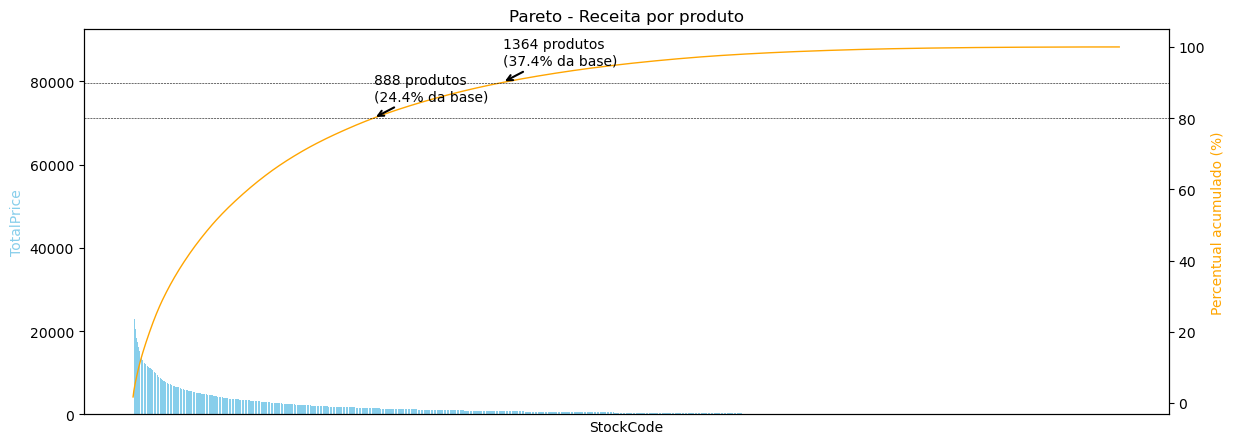

In [77]:
# Agrupar por 'StockCode', somar 'TotalPrice', ordenar em ordem decrescente
pareto_df = base_pareto.groupby('StockCode')['TotalPrice'].sum().reset_index()
pareto_df = pareto_df.sort_values(by='TotalPrice', ascending=False).reset_index(drop=True) #.head(100)

# Calcular porcentagem acumulada para o gráfico de Pareto
pareto_df['Percentual acumulado'] = pareto_df['TotalPrice'].cumsum() / pareto_df['TotalPrice'].sum() * 100

# Calcular a quantidade e porcentagem de produtos que representam 80% e 90% da receita
num_products_80pct = pareto_df[pareto_df['Percentual acumulado'] <= 80].shape[0]
percentage_products_80pct = (num_products_80pct / pareto_df.shape[0]) * 100

num_products_90pct = pareto_df[pareto_df['Percentual acumulado'] <= 90].shape[0]
percentage_products_90pct = (num_products_90pct / pareto_df.shape[0]) * 100

# Criar o gráfico de Pareto com as linhas de 80% e 90% e anotação ajustada para linha de porcentagem acumulada
fig, ax1 = plt.subplots(figsize=(14, 5))

# Barras para TotalPrice
ax1.bar(pareto_df['StockCode'], pareto_df['TotalPrice'], color='skyblue')
ax1.set_xlabel('StockCode')
ax1.set_ylabel('TotalPrice', color='skyblue')

# Linha para a porcentagem acumulada com uma linha mais fina
ax2 = ax1.twinx()
ax2.plot(pareto_df['StockCode'], pareto_df['Percentual acumulado'], color='orange', linestyle='-', linewidth=1)  # Linha ajustada
ax2.set_ylabel('Percentual acumulado (%)', color='orange')

# Linhas de referência para 80% e 90%
ax2.axhline(80, color='black', linestyle='--', linewidth=0.4)  # Linha de 80%
ax2.axhline(90, color='black', linestyle='--', linewidth=0.4)  # Linha de 90%

# Adicionar anotações para 80% e 90% com ajustes na posição
ax2.annotate(f'{num_products_80pct} produtos\n({percentage_products_80pct:.1f}% da base)',
             xy=(num_products_80pct, 80), xycoords='data',
             xytext=(num_products_80pct + 1, 85), textcoords='data',  # Movido para cima
             arrowprops=dict(arrowstyle="->", lw=1.5, color='black'),
             color='black', fontsize=10)

ax2.annotate(f'{num_products_90pct} produtos\n({percentage_products_90pct:.1f}% da base)',
             xy=(num_products_90pct, 90), xycoords='data',
             xytext=(num_products_90pct + 1, 95), textcoords='data',  # Movido para cima
             arrowprops=dict(arrowstyle="->", lw=1.5, color='black'),
             color='black', fontsize=10)

# Ocultando os rótulos do eixo x
ax1.set_xticks([])

plt.title('Pareto - Receita por produto')
plt.show()

In [79]:
# Exiba o texto formatado com as variáveis calculadas
print(f"""
Ao analisar a receita dos produtos, identificamos que {num_products_80pct} itens (representando {round(percentage_products_80pct,1)}% da base) são responsáveis por 80% da receita, enquanto {num_products_90pct} produtos (equivalente a {round(percentage_products_90pct,1)}% da base) contribuem com 90%.

Esse cenário destaca a concentração de receita em um número reduzido de produtos, sugerindo a necessidade de focar em estratégias de marketing e vendas para esses itens. Além disso, a grande quantidade de produtos que não gera receita proporcional oferece uma oportunidade para revisar o mix de produtos, potencialmente descontinuando ou reposicionando os menos rentáveis.
""")


Ao analisar a receita dos produtos, identificamos que 888 itens (representando 24.4% da base) são responsáveis por 80% da receita, enquanto 1364 produtos (equivalente a 37.4% da base) contribuem com 90%.

Esse cenário destaca a concentração de receita em um número reduzido de produtos, sugerindo a necessidade de focar em estratégias de marketing e vendas para esses itens. Além disso, a grande quantidade de produtos que não gera receita proporcional oferece uma oportunidade para revisar o mix de produtos, potencialmente descontinuando ou reposicionando os menos rentáveis.



## Segmentação de clientes com RFM

A análise **RFM** (Recência, Frequência e Valor Monetário) é uma técnica amplamente usada para segmentar clientes com base em seu comportamento de compra. Ela avalia três aspectos principais:

**Recência (R)**: Refere-se ao tempo desde a última compra do cliente. A ideia é que clientes que compraram recentemente têm maior probabilidade de fazer outra compra. Assim, quanto menor o valor de recência, melhor.

**Frequência (F)**: Mede o número de compras realizadas por um cliente em um determinado período. Clientes que compram com frequência tendem a ser mais engajados e leais, o que os torna importantes para estratégias de retenção.

**Valor Monetário (M)**: Avalia o valor total gasto pelo cliente. Clientes com um valor monetário alto são valiosos para o negócio, uma vez que geram maior receita.

### Como Funciona a Análise RFM

Os clientes são avaliados em cada uma dessas dimensões e recebem uma pontuação para cada categoria, como notas de 1 a 5, em que:

- Para Recência, valores menores indicam que o cliente comprou mais recentemente (e, portanto, é mais valioso).
- Para Frequência e Monetário, valores mais altos indicam clientes que compram frequentemente ou gastam mais.

Essas pontuações permitem agrupar os clientes com base em seus comportamentos e criar um score combinado (RFM), geralmente uma combinação das três pontuações.

Em nosso projeto, a base é dividida em quintis, o que significa que os clientes são agrupados em cinco grupos com base em sua frequência de transações, sendo que cada grupo contém aproximadamente 20% dos dados.


### Segmentos da Análise RFM

Esses segmentos ajudam a classificar os clientes de acordo com suas pontuações RFM:

1. **Hibernando**: Clientes com baixa recência e baixa frequência.
2. **Em Risco**: Clientes com baixa recência e média a alta frequência, que podem estar próximos de se tornarem inativos.
3. **Quase Inativo**: Clientes com frequência baixa e recência média, ainda ativos mas pouco engajados.
4. **Clientes Fiéis**: Clientes com recência e frequência moderadas a altas, com bom histórico de engajamento.
5. **Novos Clientes**: Clientes muito recentes e com frequência inicial baixa.
6. **Potencialmente Fiéis**: Clientes com frequência boa e recência média, com potencial para fidelização.
7. **Campeões**: Clientes com recência, frequência e valor monetário altos, representando os mais valiosos para a empresa.

No nosso projeto, optamos por utilizar apenas Recency (R) e Frequency (F) para simplificar o modelo. Além de facilitar a análise, essa escolha permite focar em métricas que promovem um relacionamento contínuo com os clientes. A Recency nos ajuda a entender a última interação do cliente, enquanto a Frequency destaca a importância da lealdade, capturando a recorrência de compras.

In [59]:
# Realizando o group by em várias variáveis e aplicando múltiplas funções de agregação
base_segmentacao = base.groupby(['CustomerID']).agg(
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum'),
    InvoiceDate_max=('InvoiceDate', 'max')).reset_index()

# Criando a coluna de recência em uma linha
base_segmentacao['Recency'] = (base_segmentacao['InvoiceDate_max'].max() + dt.timedelta(days=1) - base_segmentacao['InvoiceDate_max']).dt.days

base_segmentacao = base_segmentacao.drop(columns=['InvoiceDate_max'])

# R_score: menor recency = melhor
# Usar qcut e lidar com a possibilidade de bordas duplicadas
base_segmentacao['R_score'] = pd.qcut(base_segmentacao['Recency'], q=5, labels=False, duplicates='drop') + 1
base_segmentacao['R_score'] = 6 - base_segmentacao['R_score']  # Inverte a pontuação de R_score

# F_score: maior frequency = melhor
base_segmentacao['F_score'] = pd.qcut(base_segmentacao['Frequency'], q=5, labels=False, duplicates='drop') + 1

# M_score: maior monetary = melhor
base_segmentacao['M_score'] = pd.qcut(base_segmentacao['Monetary'], q=5, labels=False, duplicates='drop') + 1

# RFM Score
base_segmentacao["rfm_score"] = (base_segmentacao['R_score'].astype(str) + base_segmentacao['F_score'].astype(str))

# Aqui, um dicionário é criado, 
# As chaves são expressões regulares que representam diferentes combinações de scores R e F, e os valores são os segmentos rfm.
# As expressões regulares permitem identificar padrões nos scores.
seg_map = {
    r'[1-2][1-2]': 'hibernando',
    r'[1-2][3-5]': 'em_risco',
    r'[3-4][1-2]': 'quase_inativo',
    r'[3-4][3-5]': 'clientes_fiéis',
    r'5[1-2]': 'novos_clientes',
    r'[4-5][2-3]': 'potencialmente_fiéis',
    r'5[4-5]': 'campeões'
}
base_segmentacao['segment'] = base_segmentacao['rfm_score'].replace(seg_map, regex=True)

base_segmentacao.head()

,CustomerID,Frequency,Monetary,Recency,R_score,F_score,M_score,rfm_score,segment
0,12347,7,3643.58,2,5,4,5,54,campeões
1,12348,3,90.20,249,1,2,1,12,hibernando
2,12349,1,1367.55,19,4,1,4,41,quase_inativo
3,12350,1,294.40,310,1,1,2,11,hibernando
4,12352,7,1385.74,36,3,4,4,34,clientes_fiéis


### Correlações

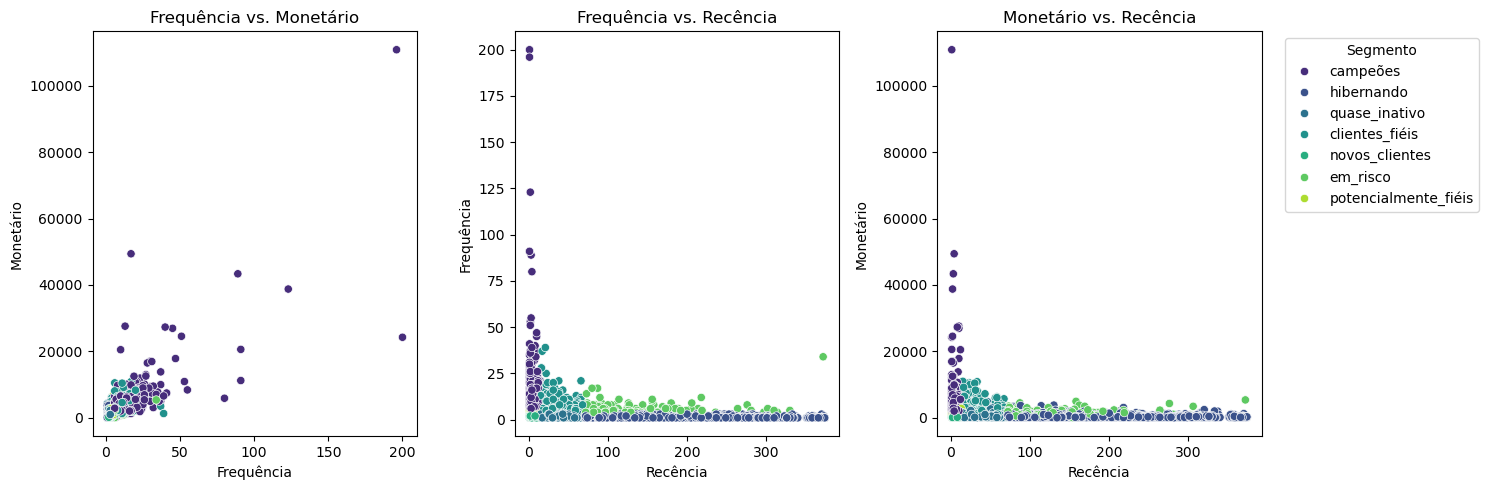

In [61]:
# Criar gráficos de dispersão
plt.figure(figsize=(15, 5))

# Frequência vs. Monetário
plt.subplot(1, 3, 1)
sns.scatterplot(data=base_segmentacao, x='Frequency', y='Monetary', hue='segment', palette='viridis', legend=False)
plt.title('Frequência vs. Monetário')
plt.xlabel('Frequência')
plt.ylabel('Monetário')

# Frequência vs. Recência
plt.subplot(1, 3, 2)
sns.scatterplot(data=base_segmentacao, x='Recency', y='Frequency', hue='segment', palette='viridis', legend=False)
plt.title('Frequência vs. Recência')
plt.xlabel('Recência')
plt.ylabel('Frequência')

# Monetário vs. Recência
plt.subplot(1, 3, 3)
sns.scatterplot(data=base_segmentacao, x='Recency', y='Monetary', hue='segment', palette='viridis')
plt.title('Monetário vs. Recência')
plt.xlabel('Recência')
plt.ylabel('Monetário')
plt.legend(title='Segmento', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Ao analisar a relação entre frequência e valor monetário, observamos que os “usuários campeões” se destacam por apresentarem as maiores frequências de compra e valores monetários, indicando uma relação forte entre engajamento e gasto.

Na análise de frequência versus recência, notamos que esses mesmos campeões também exibem as menores recências e maiores frequências, o que reforça seu engajamento. Além disso, conseguimos identificar novos clientes, que apresentam tanto uma baixa recência (compraram recentemente) quanto uma baixa frequência (ainda estão no início de suas compras).

Por fim, ao analisar apenas o valor monetário, observamos um padrão semelhante aos gráficos anteriores, onde os clientes com maior valor gasto se alinham com os grupos de maior frequência e menor recência, consolidando o perfil dos clientes mais valiosos e engajados.

### Análise dos Segmentos de Clientes

In [63]:
# Realizando o group by em várias variáveis e aplicando múltiplas funções de agregação
resumo_rfm = base_segmentacao.groupby(['segment']).agg(
    Size = ('CustomerID','count'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Recency=('Recency', 'mean'))

resumo_rfm[['Frequency', 'Monetary', 'Recency']] = resumo_rfm[['Frequency', 'Monetary', 'Recency']].round(1)

resumo_rfm.T

segment,campeões,clientes_fiéis,em_risco,hibernando,novos_clientes,potencialmente_fiéis,quase_inativo
Size,413.0,649.0,190.0,1491.0,272.0,169.0,1044.0
Frequency,15.1,7.0,5.5,1.5,2.0,4.4,1.8
Monetary,4687.5,2198.9,1398.9,406.3,557.0,1356.3,547.0
Recency,5.8,33.1,129.3,200.9,7.0,6.6,39.7


- **Campeões** e **Clientes Fiéis** são os mais lucrativos, sendo prioridade em estratégias de fidelização e benefícios exclusivos.

- **Em Risco** e **Quase Inativo** precisam de estímulos de reengajamento para evitar perdas.

- **Hibernando** pode necessitar de uma abordagem de revitalização mais intensa, ou até ser excluído de campanhas direcionadas, dependendo do custo-benefício.

- **Novos Clientes** e **Potencialmente Fiéis** são oportunidades para conversão em clientes regulares.

## Clusterização

O K-means é uma técnica de **clusterização de dados** utilizada para agrupar conjuntos de dados em clusters, ou seja, grupos de pontos com características semelhantes. É uma técnica de **aprendizado não supervisionado**, o que significa que o modelo encontra os grupos com base apenas nos dados e nas suas similaridades internas, sem conhecimento prévio de rótulos ou classes.

### Como funciona o K-means?

O K-means agrupa os dados em **K** clusters, onde **K** é um número definido pelo usuário. O algoritmo tenta minimizar a soma das distâncias dos pontos até o centro (centróide) de cada cluster, formando agrupamentos de dados compactos e bem definidos. O K-means garante uma solução onde a variabilidade dentro dos clusters é minimizada, resultando em grupos coesos.

### Vantagens do K-means

- **Simplicidade e eficiência**: O K-means é intuitivo e rápido, principalmente com grandes conjuntos de dados, o que o torna uma escolha comum para análise exploratória de dados e segmentação.
- **Escalabilidade**: A técnica é escalável e pode ser aplicada a grandes volumes de dados.
- **Flexibilidade**: K-means pode ser usado para uma ampla gama de problemas, desde a segmentação de clientes até a detecção de padrões em imagens.

### Desafios e Limitações

- **Número de clusters pré-definido**: Uma das limitações mais conhecidas é que o número de clusters \( K \) precisa ser definido previamente. Nem sempre é claro quantos clusters representam melhor os dados, e métodos como o **Elbow Method** (Cotovelo) ou a **Silhouette Analysis** (Silhueta) são usados para ajudar nessa decisão.
- **Sensibilidade à inicialização**: Como o algoritmo inicia com centróides aleatórios, ele pode encontrar diferentes resultados em cada execução. Técnicas como **K-means++** melhoram essa inicialização, levando a clusters mais consistentes.
- **Forma e densidade dos clusters**: K-means funciona melhor quando os clusters são esféricos e têm tamanhos e densidades semelhantes. Se os clusters tiverem formas ou tamanhos variados, o algoritmo pode não performar bem.

### Elbow Method (Cotovelo)

O método do cotovelo avalia a soma das distâncias ao quadrado (inércia) entre os pontos e seus respectivos centróides para diferentes quantidades de clusters (k). Ao calcular a inércia para vários valores de k e plotar esses resultados, busca-se o ponto onde a redução de inércia começa a diminuir significativamente — formando um "cotovelo" no gráfico. Esse ponto indica um número de clusters onde a adição de mais clusters não melhora significativamente a qualidade do agrupamento, sugerindo que esse é o número ideal de clusters.

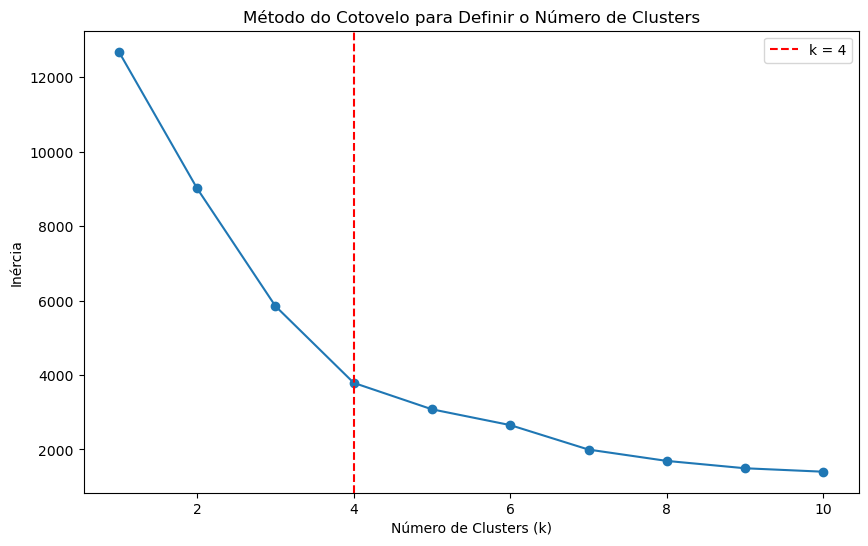

In [93]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecionando as variáveis e padronizando
X = base_segmentacao[['Frequency', 'Monetary', 'Recency']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculando a inércia para diferentes valores de k
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Defina o número ideal de clusters desejado
k_ideal = 4

# Plotando o gráfico do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.axvline(x=k_ideal, color='red', linestyle='--', label=f'k = {k_ideal}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Definir o Número de Clusters')
plt.legend()
plt.show()

In [70]:
inertia

[12684.000000000005,
 9009.892644193525,
 5849.5416674739,
 3788.1106563683616,
 3077.319970313928,
 2653.2083305512156,
 1995.7610103443712,
 1691.296307815754,
 1493.9536940052035,
 1401.0110942221488]

Para essa lista de inércia, os valores sugerem que 4 ou 5 clusters são apropriados para capturar a estrutura dos dados sem prejudicar a simplicidade do modelo.

### Silhouette Analysis (Silhueta)

O método da silhueta mede a coesão e a separação dos clusters. A silhueta varia entre -1 e 1, onde valores próximos de 1 indicam que os pontos estão bem agrupados dentro de seu cluster e distantes de outros clusters, valores próximos de 0 sugerem que os pontos estão em bordas entre clusters e valores negativos indicam que os pontos podem estar no cluster errado. Ao calcular o coeficiente de silhueta médio para diferentes valores de k, o número de clusters ideal é aquele que maximiza o valor médio da silhueta, indicando uma boa separação entre os clusters.

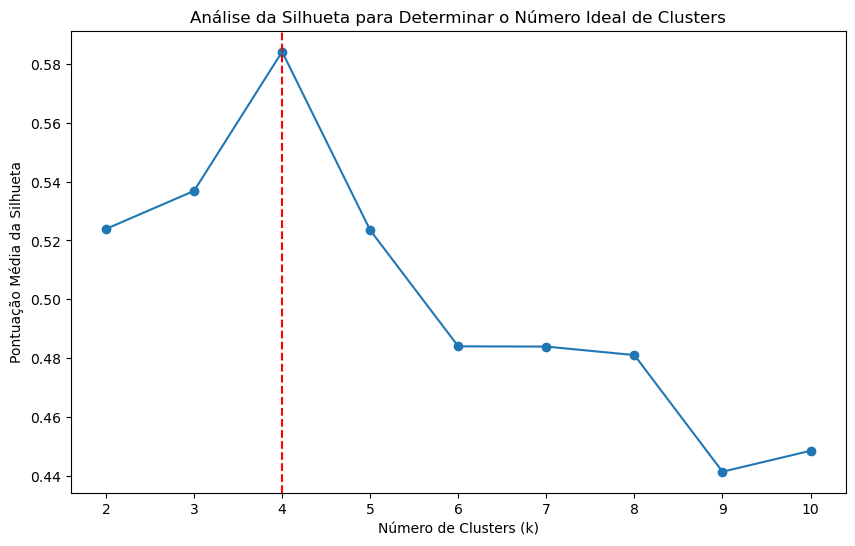

In [73]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Calculando a pontuação da silhueta para diferentes valores de k
silhouette_scores = []
k_range = range(2, 11)  # Começamos de 2 porque k=1 não é aplicável para silhueta

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.axvline(x=4, color='red', linestyle='--', label='k = 4')  # Linha pontilhada em vermelho no k=4
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação Média da Silhueta')
plt.title('Análise da Silhueta para Determinar o Número Ideal de Clusters')
plt.show()


In [316]:
silhouette_scores

[0.523916243174347,
 0.5368619419747467,
 0.5841592736349628,
 0.523470159214007,
 0.48401365776868954,
 0.48393066947472435,
 0.4810424069062999,
 0.4413921807670107,
 0.44851023586638383]

Esses valores representam as pontuações médias de silhueta para diferentes números de clusters, variando de 
k=2 a 𝑘 = 10.

Com base nos valores, temos a seguinte interpretação:

O valor mais alto de silhueta ocorre com k=4 (0.584), indicando que quatro clusters podem ser a melhor escolha, com a maior coesão e separação entre os clusters. Para 𝑘>4, as pontuações de silhueta começam a diminuir, indicando que mais clusters começam a gerar sobreposição entre grupos, enfraquecendo a definição dos clusters.
Portanto, quatro clusters parecem ser a quantidade ideal para este conjunto de dados, pois maximizam a pontuação de silhueta, sugerindo uma boa separação e estrutura clara entre os clusters.

In [80]:
kmeans = KMeans(n_clusters=k_ideal, random_state=42)
base_segmentacao['Cluster'] = kmeans.fit_predict(X_scaled)+1

In [82]:
# Visualizando os resultados
#base_segmentacao[['CustomerID', 'Frequency', 'Monetary', 'Recency', 'Cluster']]

base_segmentacao.groupby(['Cluster']).agg(
    Size = ('CustomerID','count'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Recency=('Recency', 'mean'))

,Size,Frequency,Monetary,Recency
Cluster,,,,
1,2906,3.459050,997.671917,43.645217
2,1062,1.530132,386.173588,246.810734
3,4,152.000000,54299.682500,1.750000
4,256,19.050781,6483.917891,13.496094


### Resumo da Análise
- **Cluster 1**: Base de clientes moderadamente ativos com compras esporádicas e gasto médio.
- **Cluster 2**: Clientes inativos ou com engajamento mínimo, que contribuem menos para a receita.
- **Cluster 3**: Grupo VIP, muito valioso, com altíssima frequência e gasto, e recência quase imediata.
- **Cluster 4**: Clientes leais, de alto valor, com boa frequência e gasto, também bastante ativos.

### Implicações para Estratégias de Marketing
- **Cluster 1**: Manter a frequência de compras e engajamento pode ser interessante por meio de campanhas promocionais e ofertas personalizadas para aumentar o valor médio de gasto.
- **Cluster 2**: Estratégias de reativação, como descontos exclusivos, podem ajudar a incentivar esses clientes a retornarem.
- **Cluster 3**: Esses clientes VIPs podem ser beneficiados com programas de fidelidade e experiências exclusivas.
- **Cluster 4**: Fortalecer a relação com esses clientes leais através de benefícios e conteúdo exclusivo é uma boa estratégia para mantê-los engajados.

## Conclusão

Neste projeto de análise de clientes de e-commerce, integramos as abordagens de *Cohort*, *Pareto*, *RFM* e *clusterização*, proporcionando uma visão completa sobre o comportamento e valor dos clientes. 

### Conclusão do Projeto
- **Análise de Cohort**: Identificou taxas de retenção e fidelidade, apontando períodos críticos de queda, permitindo intervenções para retenção.
  
- **Análise de Pareto**: Aplicando o princípio 80/20, destacamos o grupo de clientes mais valioso, fundamental para a saúde financeira do e-commerce.

- **Análise RFM**: Segmentou os clientes por recência, frequência e valor monetário, destacando os mais leais e potenciais inativos, indicando oportunidades de personalização e retenção.

- **Clusterização de Clientes**: Usando KMeans, agrupamos clientes em clusters assim como na análise RFM, facilitando estratégias de marketing direcionadas. 

Essas técnicas, juntas, permitiram uma maior compreensão sobre as dinâmicas de compra, ajudando a definir ações personalizadas para fidelizar e aumentar o valor do cliente.

## Referências

- https://www.kaggle.com/code/mustafacicek/detailed-marketing-cohort-pareto-rfm-forecast/notebook
- https://www.kaggle.com/code/farzadnekouei/customer-segmentation-recommendation-system
- https://medium.com/analytics-vidhya/e-commerce-data-exploratory-data-analysis-eda-99b17cf53765
- https://amplitude.com/blog/how-to-calculate-retention-rate-b2b-saas